# <tt>synphot</tt>: Predicting count rates with ground-based and space-based telescopes

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using <code>astropy.coordinates.Skycoord</code>, <code>astroquery.Gaia</code>, <code>astropy.io</code>, and <code>astropy.utils</code></li>
<li>Construct a source spectrum from a model spectrum using <code>synphot.SourceSpectrum</code></li>
<li>Simulate bandpass throughput with <code>synphot.SpectralElement</code></li>
<li>Model effects on the source spectrum such as atmospheric transmission and quantum efficiency with <code>synphot.SpectralElement</code></li>
<li>Combine all of these effects into a simulated observation with <code>synphot.Observation</code></li>
<li>Compute the expected count rate from this observation with <code>synphot</code>'s <code>countrate()</code> function
</ul>

## Keywords
synphot, synthetic photometry, astropy, astroquery, astronomy

## Summary
<a href="https://synphot.readthedocs.io/en/latest/#" target="_blank"><tt>synphot</tt></a> is an astropy-affiliated package for creating synthetic photometry in Python. In this tutorial we will show how to predict the total counts expected to be measured by both a ground-based telescope and a space-based telescope using model spectra. Specifically, we will:
<ol>
<li><a href="#query_properties">Query the properties of a target star</a></li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#source_spectrum">Construct a source spectrum</a></li>
<li><a href="#bandpass">Create the bandpass of observation</a></li>
<li><a href="#atmosphere">Model attenuation by the atmosphere</a></li>
<li><a href="#qe">Model the effect of the CCD's quantum efficiency</a></li>
<li><a href="#observation">Combine all of the effects and "observe"</a></li>
<li><a href="#counts">Compute the count rate and total counts</a></li>
<li><a href="#trappist1">Look at another example, this time with TRAPPIST-1</a></li>
<li><a href="#kepler">Simulate observations with a space-based telescope</a></li>
<li><a href="#compare">Compare <tt>synphot</tt> counts to observed counts</a></li>
</ol>

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.utils.data import download_file

from astroquery.gaia import Gaia

from synphot import units
from synphot.spectrum import SourceSpectrum, SpectralElement
from synphot.models import Empirical1D
from synphot.observation import Observation

# LOCAL
import skymodel

# the following is just to silence nonintegral warnings
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.filterwarnings("ignore", module='astropy.io.votable.tree')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

<a id='query_properties'></a>
## 1. Query the properties of HAT-P-11

In this tutorial we will use a couple of example stars, the first being <a href="https://en.wikipedia.org/wiki/HAT-P-11" target="_blank">HAT-P-11</a>. In order to model its spectrum with PHOENIX, we will need to get some of HAT-P-11's  parameters, which we can do using <tt>astroquery</tt>'s <a href="https://astroquery.readthedocs.io/en/latest/gaia/gaia.html">Gaia query</a> and astropy's <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html"><tt>SkyCoord</tt></a>: 

In [172]:
ID = 'HAT-P-11'

coord = SkyCoord.from_name(ID)
# width / height of search:
width = u.Quantity(1, u.arcmin)
height = u.Quantity(1, u.arcmin)

search_results = Gaia.query_object_async(coordinate=coord, width=width, height=height)
# the queried star should be the one nearest to the given coordinates
search_results.add_index('dist', unique=True)
hatp11_info = search_results.loc['dist', min(search_results['dist'])]

stellar_radius = hatp11_info['radius_val'] * u.R_sun
# divide 1 AU by parallax (arcseconds) to get distance in parsecs.
# parallax is given in milliarcseconds, so multiply by 1000: 
distance = (1 / (hatp11_info['parallax']) * 1000) * u.pc
T_eff = hatp11_info['teff_val'] * u.K

Query finished.


In [173]:
print("Temperature of HAT-P-11 =", T_eff)
print("Distance to HAT-P-11 =", distance)

Temperature of HAT-P-11 = 4757.26708984375 K
Distance to HAT-P-11 = 37.80607118315159 pc


<a id="phoenix"></a>
## 2. Download a PHOENIX model spectrum for HAT-P-11

We will model the spectrum of HAT-P-11 with a <a href="https://arxiv.org/abs/1303.5632" target="_blank">PHOENIX</a> stellar atmosphere model, which we can obtain by specifying a stellar temperature and querying from the <a href="http://phoenix.astro.physik.uni-goettingen.de/" target="_blank">Gottingen Spectral Library</a>:

In [174]:
T_eff = round(T_eff.value, -2)  # round to nearest 100 K

flux_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=int(T_eff), log_g=4.5)
wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')

flux = fits.getdata(flux_url)
wavelengths = fits.getdata(wavelength_url)

It is good practice (and for some packages, essential) to attach units to quantities so that you can be sure the final results are scaled correctly. The units we use here are specified by the PHOENIX models.

In [175]:
flux = flux * (u.erg / u.s / u.cm ** 2 / u.cm) 
wavelengths = wavelengths * u.Angstrom

<a id="source_spectrum"></a>
## 3. Construct a <tt>synphot</tt> source spectrum object

To do synthetic photometry with synphot, you must first make an object out of your target's spectrum with <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays"><tt>synphot.spectrum.SourceSpectrum</tt></a>. Since we are constructing the source spectrum from arrays of data, we specify that the model type is Empirical1D and pass in the arrays (e.g. <code>points=wavelengths</code> and <code>lookup_table=flux</code>): 

In [176]:
photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
photlam_hatp11 = photlam_hatp11 * float(stellar_radius / distance) ** 2 / np.pi

<tt>SourceSpectrum</tt> objects come with a useful <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum.plot" target="_blank">plotting method</a> for easy viewing of the spectrum: 

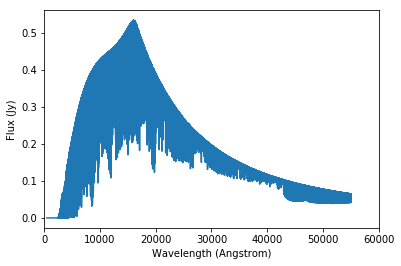

In [177]:
photlam_hatp11.plot(flux_unit='Jy', left=0, right=60000)

(for other methods of constructing source spectra with <tt>synphot</tt>, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

<a id="bandpass"></a>
## Now we will simulate the observation with a specific instrument

<p>Let's observe HAT-P-11 with the <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/">ARCTIC instrument</a> on APO's 3.5m telescope, which has the following specs:

In [178]:
aperture_radius = 3.5 / 2 * u.m  # radius of 3.5m ARC telescope at APO
aperture_area = np.pi * aperture_radius ** 2
gain = 1.9  # the gain of this detector in e-/ADU

## 4.  Create the bandpass

Next we want to model the effect of observing this object through a couple of bandpasses, specifically the r' and z' filters from the Sloan Digital Sky Survey (SDSS). Similar to how we made the spectral data into a synphot object, we will also need to construct bandpass objects so that the two can be easily convolved.

To obtain the filter transmission functions of the SDSS bandpasses, we use <a href="https://docs.astropy.org/en/stable/api/astropy.utils.data.download_file.html" target="_blank"><tt>astropy.utils.data.download_file</tt></a> to download the transmission file from the <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice" target="_blank">Spanish Virtual Observatory</a> filter database. 

To construct a bandpass from a file, use <tt>synphot.spectrum</tt>'s <tt>SpectralElement</tt> <a href="https://synphot.readthedocs.io/en/latest/synphot/bandpass.html#file" target="_blank">with its <tt>from_file</tt></a> method:

In [179]:
sdss = ['rprime', 'zprime']  # only want r' and z' bands for now
svo_link = ('http://svo2.cab.inta-csic.es/' +
           'theory/fps3/fps.php?ID=')

bandpasses = {}
for band in sdss:
    filt_path = download_file(svo_link + 'SLOAN/SDSS.' + band + '_filter')
    bandpasses[band] = SpectralElement.from_file(filt_path)

Like <tt>SourceSpectrum</tt> objects, <tt>SpectralElement</tt> objects also have a handy plotting method:

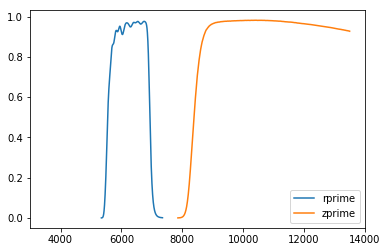

In [180]:
for band in sdss:
    waves = bandpasses[band].waveset
    plt.plot(waves, bandpasses[band](waves), label=band)
    
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()

For other methods of building bandpasses (either from a model or from one of <tt>synphot</tt>'s given bandpasses), <a href="https://synphot.readthedocs.io/en/latest/synphot/bandpass.html" target="_blank">see here</a>.

<a id="atmosphere"></a>
## 5. Model the attenuation by the atmosphere

<tt>SpectralElement</tt> can also be used to model other effects on the observation, such as atmospheric transmittance or a CCD's response function. Here we will model the atmospheric transmittance using the local script <tt>skymodel.py</tt>, which queries results from the <a href="http://etimecalret-001.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC">SkyCalc Sky Model Calculator</a> (the default location is the Paranal Observatory, which is similar in climate to APO):

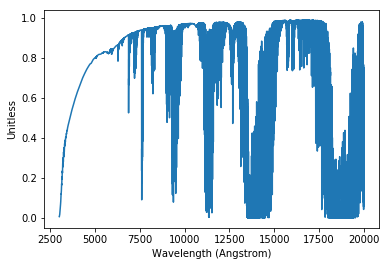

In [181]:
trans_waves, transmission = skymodel.get_atmospheric_transmittance(airmass=1.5)

atmosphere = SpectralElement(Empirical1D,
                             points=trans_waves,
                             lookup_table=transmission)
atmosphere.plot()

<a id="qe"></a>
## 6. Model the effect of the CCD's quantum efficiency

For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a> of the instrument's website, which we've saved into the local file ccd_QE.csv. Because the wavelength units are not the same as <tt>synphot's</tt> default unit of Angstroms, we have to specify the units with the <tt>wave_unit</tt> keyword.

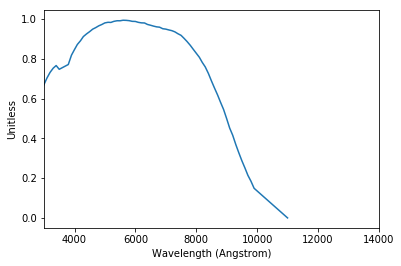

In [182]:
quantum_efficiency = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
quantum_efficiency = quantum_efficiency / 100  # convert percentages to fractions

quantum_efficiency.plot(left=3000, right=14000)

<a id="observation"></a>
## 7. Combine all of the effects and "observe"

Once we have all of the effects on the source spectrum set, we can combine them (i.e. convolve them) by simply multiplying the <tt>SpectralElement</tt> objects together:

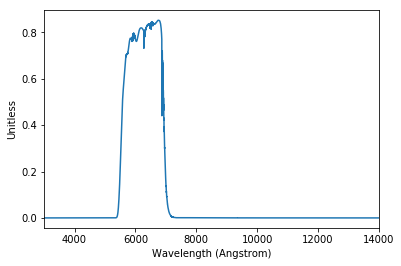

In [183]:
bp_atmos_qe = {}  # for the combined bandpass, atmosphere, and quantum efficiency element
for band in sdss:
    bp_atmos_qe[band] = bandpasses[band] * atmosphere * quantum_efficiency
    
bp_atmos_qe['rprime'].plot(left=3000, right=14000)

Finally, we convolve the source spectrum with all of these effects using <tt>synphot.observation</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html"><tt>Observation</tt></a>:

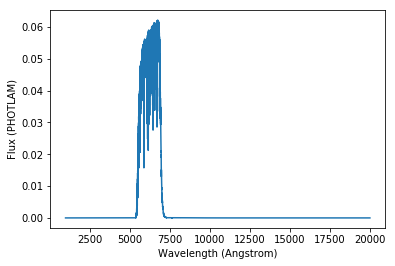

In [184]:
band = 'rprime'  # only want to know about the r' band for this star

observation = Observation(photlam_hatp11, bp_atmos_qe[band])
observation.plot()

<a id="counts"></a>
## 8. Compute the count rate and total counts

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate"><tt>countrate()</tt></a> method on the observation object. If you wish to compare <tt>synphot</tt> counts to measured counts (as we will do at the end of the tutorial), you may have to divide the predicted count rate by your instrument's gain depending on how the instruments defines its counts.

In [185]:
countrate = observation.countrate(area=aperture_area) / gain
countrate

<Quantity 3835363.89184525 ct / s>

How many counts can we expect in a 10s exposure?

In [186]:
exptime = 10 * u.s
apo_counts_hatp11 = countrate * exptime

print("HAT-P-11 counts in the r-band, 10 s exposure:")
print(int(apo_counts_hatp11.value), "cts")

HAT-P-11 counts in the r-band, 10 s exposure:
38353638 cts


<a id="trappist1"></a>
## 9. Another example, this time observing <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a>

(using the same instrument and telescope)

In [187]:
T_eff = 2600  # approx temperature of trappist-1 [K], Gillon 2017

flux_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')

flux = fits.getdata(flux_url) * (u.erg / u.s / u.cm ** 2 / u.cm)
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Unfortunately Gaia does not have all the parameters we need for TRAPPIST-1, so we use the values cited in <a href="https://arxiv.org/pdf/1703.01424.pdf">Gillon 2017</a>:

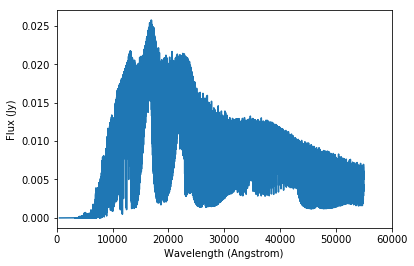

In [188]:
photlam_trappist1 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
stellar_radius = 0.117 * u.R_sun  # radius of trappist-1 in solar units
distance = 12.1 * u.pc  # distance to trappist-1 in parsecs
photlam_trappist1 = photlam_trappist1 * float(stellar_radius / distance) ** 2 / np.pi

photlam_trappist1.plot(flux_unit='Jy', left=0, right=60000)

This time I just want to know about observations in the SDSS z'-band. Since we have already constructed the <tt>SpectralElement</tt> for the combined effects of the bandpass, atmosphere, and CCD of this instrument (<tt>bp_atmos_qe</tt>), simulating the observation is as simple as referencing that <tt>SpectralElement</tt> for the band of interest:

In [189]:
band = 'zprime'

observation = Observation(photlam_trappist1, bp_atmos_qe[band])

How many counts can we expect to measure in a 10s exposure of TRAPPIST-1 with APO's ARCTIC?

In [190]:
countrate = observation.countrate(area=aperture_area) / gain
apo_counts_trappist1 = countrate * 10 * u.s

print("TRAPPIST-1 counts in the z-band, 10 s exposure:")
print('\t', int(apo_counts_trappist1.value), "cts")

TRAPPIST-1 counts in the z-band, 10 s exposure:
	 306750 cts


<a id="kepler"></a>
## 10. Predicting photon counts of the same stars, this time observed by a space-based telescope

In this example we will use <a href="https://en.wikipedia.org/wiki/Kepler_space_telescope">Kepler</a> as our space telescope.

First we will need to know Kepler's response function, which we can obtain from SVO (this response function includes both the bandpass and the quantum efficiency of the CCD):

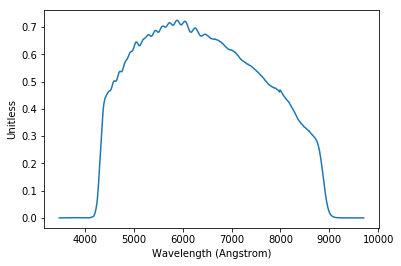

In [191]:
filt_path = download_file(svo_link + 'Kepler/Kepler.K')
kepler_response = SpectralElement.from_file(filt_path)

kepler_response.plot()

Create the observation object. Since Kepler is a space-based telescope, we do not need to convolve with an atmospheric transmission function:

In [192]:
# here I choose to organize the observations in a dictionary,
# but you can do whatever works best for you
kepler_stars = {'hatp11': {'spectrum': photlam_hatp11},
                'trappist1': {'spectrum': photlam_trappist1}
               }

for star in kepler_stars:
    kepler_stars[star]['observation'] = Observation(stars[star]['spectrum'], kepler_response)

Compute the counts in a 10 second exposure for the two stars:

In [193]:
kepler_area = np.pi * (1.4 * u.m / 2) ** 2  # area of Kepler's primary mirror

for star in kepler_stars:
    countrate = kepler_stars[star]['observation'].countrate(area=kepler_area)
    kepler_stars[star]['counts'] = countrate * 10 * u.s
    
print('counts predicted by synphot in 10s exposure:')
print('\t HAT-P-11:', round(kepler_stars['hatp11']['counts'].value / 1e6, 1), 'million')
print('\t TRAPPIST-1', round(kepler_stars['trappist1']['counts'].value / 1e3, 1), 'thousand')

counts predicted by synphot in 10s exposure:
	 HAT-P-11: 24.7 million
	 TRAPPIST-1 65.0 thousand


<a id="compare"></a>
## 11. How well does <tt>synphot</tt> do?

Let's compare the <tt>synphot</tt> counts to some measured counts to see how well <tt>synphot</tt> can perform. We know from real observations (taken with ARCTIC on APO's 3.5m telescope and with Kepler) that the actual count values for these stars are:

In [194]:
hatp11_r_apo_meas = 34000000
hatp11_kepler_meas = 28000000
trappist1_z_apo_meas = 203000
trappist1_kepler_meas = 57000

An easy way to compare is to plot the <tt>synphot</tt> values to the observed values on a 1-1 line:

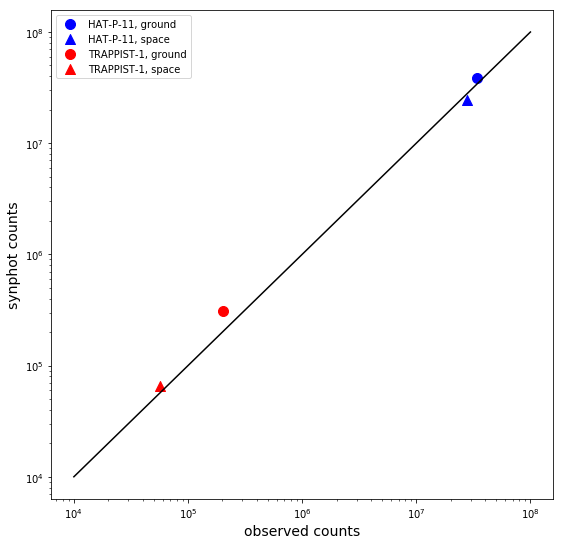

In [195]:
fig = plt.figure(figsize=(9, 9))

plt.scatter(hatp11_r_apo_meas, apo_counts_hatp11,
            color='b', s=100, label="HAT-P-11, ground")
plt.scatter(hatp11_kepler_meas, kepler_stars['hatp11']['counts'],
            color='b', marker= '^', s=100, label="HAT-P-11, space")
plt.scatter(trappist1_z_apo_meas, apo_counts_trappist1,
            color='r', s=100, label='TRAPPIST-1, ground')
plt.scatter(trappist1_kepler_meas, kepler_stars['trappist1']['counts'],
            color='r', marker= '^', s=100, label='TRAPPIST-1, space')

# one-to-one line
countrange = np.linspace(1e4, 1e8, 20)
plt.plot(countrange, countrange, color='black')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('synphot counts', size='14')
plt.xlabel('observed counts', size='14')

plt.legend()

What are the % errors?

In [196]:
print('Ground-based:')
print('\t HAT-P-11 in r-band:',
      int(abs(apo_counts_hatp11.value - hatp11_r_apo_meas) /
          hatp11_r_apo_meas * 100), "%")
print('\t TRAPPIST-1 in z-band:',
     int(abs(apo_counts_trappist1.value - trappist1_z_apo_meas) /
          trappist1_z_apo_meas * 100), "%")
print('Space-based:')
print('\t HAT-P-11:',
      int(abs(kepler_stars['hatp11']['counts'].value
              - hatp11_kepler_meas) /
          hatp11_kepler_meas * 100), "%")
print('\t TRAPPIST-1',
      int(abs(kepler_stars['trappist1']['counts'].value
              - trappist1_kepler_meas) /
          trappist1_kepler_meas * 100), "%")

Ground-based:
	 HAT-P-11 in r-band: 12 %
	 TRAPPIST-1 in z-band: 51 %
Space-based:
	 HAT-P-11: 11 %
	 TRAPPIST-1 14 %


Not too bad!